Здесь я решил воспользоваться стредствами sklearn по отбору лучших фичей, уменьшв их количество примерно до 5 штук, чтобы можно было посмотреть на pairplot и сравнить с тем, что я получил в прошлом ноутбуке, а также протестировать на них knn

In [33]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [4]:
train_df = pd.read_csv('data/PD-data-train.csv', sep=';')
test_df = pd.read_csv('data/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('data/PD-data-desc.csv', sep=';')

In [5]:
train_df = pd.concat([train_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=train_df['ul_staff_range'])], axis=1)
test_df = pd.concat([test_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=test_df['ul_staff_range'])], axis=1)

In [6]:
train_cols = train_df.columns
test_cols = test_df.columns

In [7]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df = pd.DataFrame(imp_mean.fit_transform(train_df), columns=train_cols)
test_df = pd.DataFrame(imp_mean.fit_transform(test_df), columns=test_cols)

In [20]:
data, target = train_df.drop(columns=['default_12m']), train_df['default_12m']

- согласно api sklearn, базовая стратегия SelectKBest расчитана на задачу классификации, поэтому её я менять не буду, указав лишь количество нужных фичей в качестве параметра
- при значении k=5 некоторые стобцы были абсолютно идентичны, по этой причине выбрал значение k=3

In [21]:
data_new = SelectKBest(k=3).fit_transform(data, target)

/home/kira/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [34] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/kira/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [24]:
check = pd.DataFrame(data_new, columns=['f1', 'f2', 'f3'])
check = pd.concat([check, target], axis=1)

In [26]:
check.head()

,f1,f2,f3,default_12m
0,198.0,136.0,3.0,0.0
1,256.0,135.0,12.0,0.0
2,33.0,33.0,28.0,0.0
3,185.0,139.0,8.0,0.0
4,220.0,138.0,27.0,0.0


- в попарных комбинациях фичей ситуация с взаимным расположением объектов двух классов действительно та же, что дает больше уверенности в пользу нелинейных моделей
- хочется заметить, что это больше похоже на графики именно проблемы разреженной сбалансировки, о которой я упоминал в ноутбуках ранее, нежели проблемы дисбаланса классов 

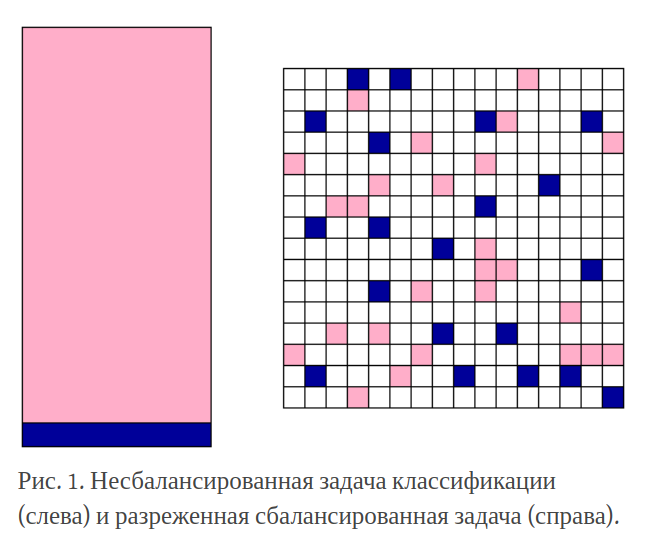

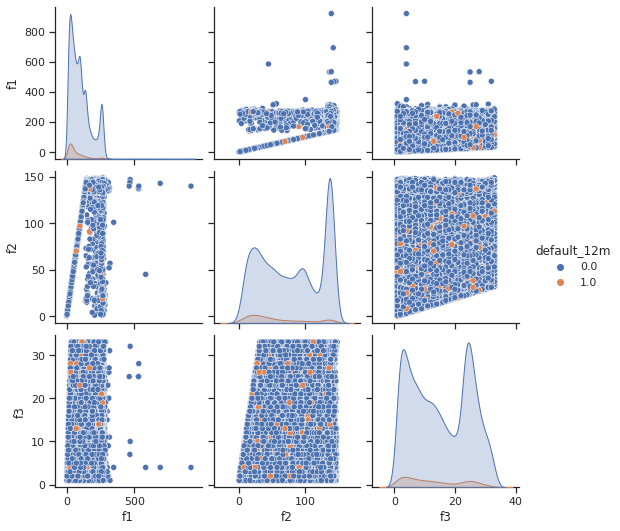

In [28]:
sns.set_theme(style="ticks")
sns.pairplot(check, hue="default_12m")

In [35]:
clf = KNeighborsClassifier()
cv_baseline = cross_val_score(clf, data_new, target, scoring='accuracy').mean()
cv_baseline

0.9309152647013429

Получаем несколько лучший скор, чем у knn + simple oversampling